<a href="https://colab.research.google.com/github/Jules-gatete/ML-Techniques-I---CHATBOT/blob/main/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔧 STEP 1: Install Dependencies

In [222]:
!pip install --upgrade datasets -q
!pip install tensorflow transformers evaluate seaborn nltk wordcloud -q
!pip install --upgrade datasets -q
!pip install tensorflow transformers evaluate seaborn nltk wordcloud rouge_score -q

  Preparing metadata (setup.py) ... done


# 📦 STEP 2: Import Libraries


In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import numpy as np
from datasets import load_dataset, Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from transformers import T5Tokenizer, TFT5ForConditionalGeneration, DataCollatorForSeq2Seq, create_optimizer, Trainer, TrainingArguments
import tensorflow as tf

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

# 📊 STEP 3: Load the Dataset


In [146]:
dataset = load_dataset("abamerdeen/insurance-qa")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 2988
    })
    validation: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 175
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 351
    })
})


In [74]:
# Convert to DataFrame for EDA
df = pd.DataFrame(dataset['train'])

In [149]:
# Show basic stats
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   context          2988 non-null   object
 1   question         2988 non-null   object
 2   answer           2988 non-null   object
 3   question_length  2988 non-null   int64 
 4   answer_length    2988 non-null   int64 
 5   clean_question   2988 non-null   object
 6   clean_answer     2988 non-null   object
dtypes: int64(2), object(5)
memory usage: 163.5+ KB
None
  context                                           question  \
0             when does universal life insurance make sense?   
1             how long has whole life insurance been around?   
2              how does an agent get paid on life insurance?   
3                      can nursing home take life insurance?   
4          can you contest the beneficiary of life insura...   

                                              a

In [75]:
# Show basic stats
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   2988 non-null   object
 1   question  2988 non-null   object
 2   answer    2988 non-null   object
dtypes: object(3)
memory usage: 70.2+ KB
None


,context,question,answer
0,,when does universal life insurance make sense?,Universal life insurance makes sense in severa...
1,,how long has whole life insurance been around?,The provided knowledge does not contain specif...
2,,how does an agent get paid on life insurance?,"According to the information provided, the ins..."
3,,can nursing home take life insurance?,", it does not appear that a nursing home can d..."
4,,can you contest the beneficiary of life insura...,", the following points can be made regarding c..."


📊 STEP 4: Exploratory Data Analysis (EDA)


In [150]:
# Ensure no NaN values for EDA
df['question'] = df['question'].fillna("")
df['answer'] = df['answer'].fillna("")

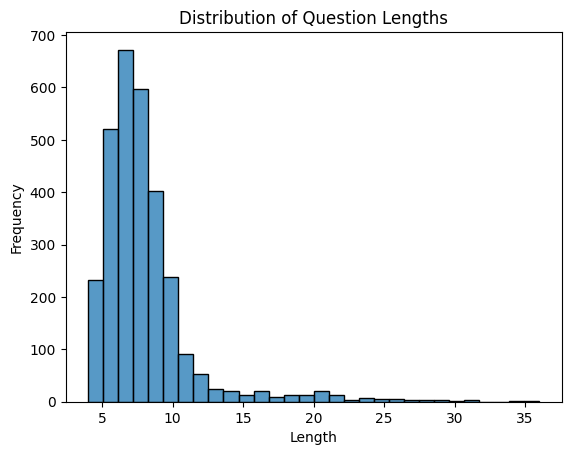

In [151]:
# Question length distribution
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
sns.histplot(df['question_length'], bins=30)
plt.title("Distribution of Question Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

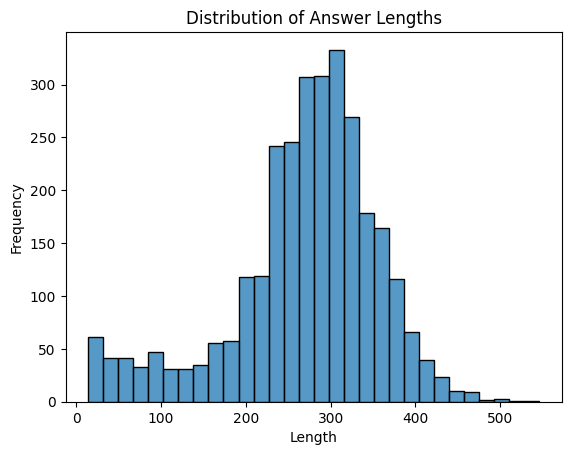

In [152]:
# Answer length distribution
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))
sns.histplot(df['answer_length'], bins=30)
plt.title("Distribution of Answer Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

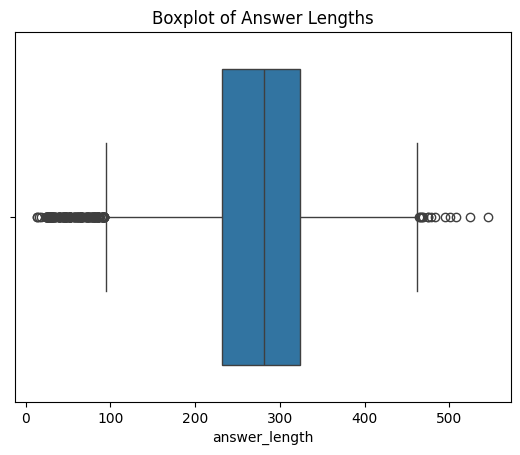

In [84]:
# Most common answer lengths
sns.boxplot(data=df, x='answer_length')
plt.title("Boxplot of Answer Lengths")
plt.show()



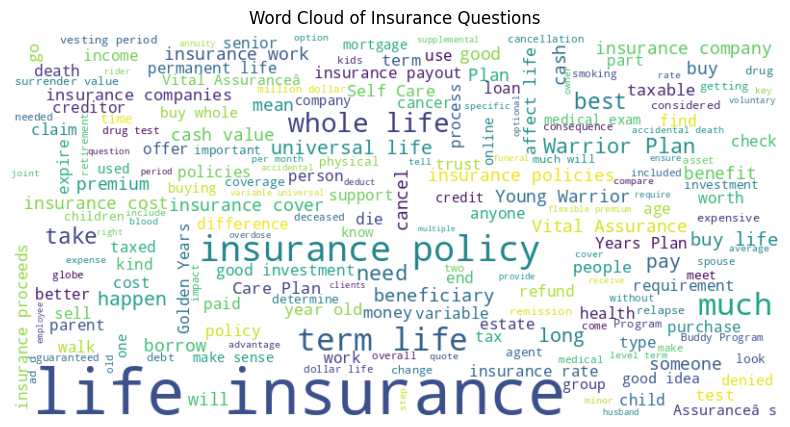

In [85]:
# 🆕 Word cloud of top terms in questions
from wordcloud import WordCloud
text = ' '.join(df['question'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Insurance Questions")
plt.show()

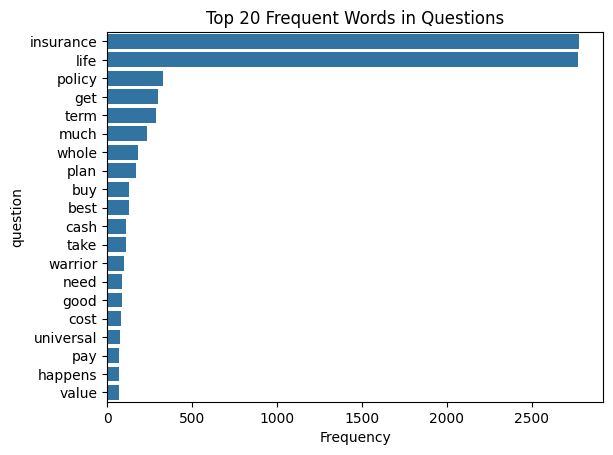

In [156]:
# Top 20 frequent words in questions (excluding stopwords)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words]

all_words = df['question'].apply(clean_text).explode()
freq_words = all_words.value_counts().head(20)

sns.barplot(x=freq_words.values, y=freq_words.index)
plt.title("Top 20 Frequent Words in Questions")
plt.xlabel("Frequency")
plt.show()

🔍 STEP 5: Preprocessing Function


In [157]:
def preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    return text.strip()

# Apply preprocessing
df['question'] = df['question'].fillna("")
df['answer'] = df['answer'].fillna("")
df['clean_question'] = df['question'].apply(preprocess)
df['clean_answer'] = df['answer'].apply(preprocess)

# Check for missing values
print("Missing values:\n", df[['clean_question', 'clean_answer']].isnull().sum())

# Save preprocessed data if file doesn't exist
import os
if not os.path.exists("processed_insurance_qa.csv"):
    df[['clean_question', 'clean_answer']].to_csv("processed_insurance_qa.csv", index=False)

Missing values:
 clean_question    0
clean_answer      0
dtype: int64


🧠 STEP 6: Tokenization & Dataset Preparation


In [201]:
from transformers import T5Tokenizer
from datasets import Dataset

tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=False)
max_input_length = 64
max_target_length = 128

def tokenize_function(example):
    # T5 expects input text to start with a task prefix like "question: "
    input_texts = ["question: " + q for q in example["clean_question"]]
    target_texts = example["clean_answer"]

    model_inputs = tokenizer(
        input_texts,
        max_length=64,
        padding="max_length",
        truncation=True
    )

    # Tokenize targets and replace padding token IDs with -100
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_texts,
            max_length=128,
            padding="max_length",
            truncation=True
        )

    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs





In [202]:
# Convert DataFrame to Dataset and split
df = df.dropna(subset=['clean_question', 'clean_answer']).reset_index(drop=True)
hf_dataset = Dataset.from_pandas(df[['clean_question', 'clean_answer']])
split_dataset = hf_dataset.train_test_split(test_size=0.1, seed=42)

train_ds = split_dataset['train']
val_ds = split_dataset['test']

# Tokenize datasets
tokenized_train_ds = train_ds.map(tokenize_function, batched=True, remove_columns=['clean_question', 'clean_answer'])
tokenized_val_ds = val_ds.map(tokenize_function, batched=True, remove_columns=['clean_question', 'clean_answer'])

# Debug: Verify tokenized dataset
print("Sample from tokenized_train_ds:", tokenized_train_ds[0])
print("Features in tokenized_train_ds:", tokenized_train_ds.features)

Map:   0%|          | 0/2689 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/299 [00:00<?, ? examples/s]

Sample from tokenized_train_ds: {'input_ids': [822, 10, 149, 19, 3362, 12203, 7, 365, 9933, 2842, 21, 14032, 114, 8, 7069, 203, 515, 7641, 29, 17, 45, 879, 1032, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [3362, 12203, 349, 7, 365, 9933, 433, 21, 14032, 1989, 365, 8, 7069, 203, 515, 19, 3346, 11051, 12, 1115, 8, 775, 523, 11, 4616, 13, 2749, 3513, 48, 1295, 7641, 7, 4019, 45, 879, 365, 9933, 2869, 3115, 2930, 12, 3, 9, 3, 13627, 14798, 536, 24687, 365, 9933, 8, 7069, 203, 515, 5936, 7, 3, 9, 24687, 365, 9933, 433, 24, 2311, 163, 3, 9, 3117, 1035, 892, 11, 3, 9, 1722, 691, 413, 9770, 879, 2869, 24, 164, 7789, 3616, 16879, 3, 15267, 4293, 42, 1561, 1035, 5002, 7, 48, 3, 26474, 1295, 19, 876

📦 STEP 7: Prepare Dataset for TensorFlow


In [200]:
# 📦 STEP 7: Prepare Dataset for TensorFlow
from transformers import TFT5ForConditionalGeneration, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
import numpy as np

# Initialize model and data collator
model = TFT5ForConditionalGeneration.from_pretrained('t5-small')
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

# ✅ FIXED: Use label_cols to pass labels correctly
tf_train_dataset = tokenized_train_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    label_cols="labels",
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
)

tf_val_dataset = tokenized_val_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    label_cols="labels",
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator
)



All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


🏋️‍♂️ STEP 8: Train the Model

In [206]:
# 🧠 STEP 8: Train the Model with Custom EarlyStopping
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', patience=3, restore_best_weights=True):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_loss = np.inf
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is None:
            return
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_epoch = epoch
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        elif epoch - self.best_epoch >= self.patience:
            print(f"\nEarly stopping at epoch {epoch+1}: {self.monitor} did not improve for {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print("Restoring best weights.")
                self.model.set_weights(self.best_weights)

# Compile the model
num_train_steps = len(tf_train_dataset) * 5
optimizer, schedule = create_optimizer(
    init_lr=3e-4,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)
model.compile(optimizer=optimizer, loss=model.compute_loss)

# Recreate optimizer and compile the model
optimizer, schedule = create_optimizer(
    init_lr=3e-4,
    num_warmup_steps=0,
    num_train_steps=len(tf_train_dataset) * 5
)

model.compile(optimizer=optimizer, loss=model.compute_loss)

In [216]:
from tensorflow.keras.callbacks import EarlyStopping

# 🩹 Patch all 3 required methods
EarlyStopping._implements_train_batch_hooks = lambda self: False
EarlyStopping._implements_test_batch_hooks = lambda self: False
EarlyStopping._implements_predict_batch_hooks = lambda self: False

# ✅ Define EarlyStopping as usual
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# ✅ Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=3,
    callbacks=[early_stopping]
)


Epoch 1/3
337/337 [==============================] - 3355s 10s/step - loss: 3.2935 - val_loss: 2.5656
Epoch 2/3
337/337 [==============================] - 3173s 9s/step - loss: 2.7343 - val_loss: 2.3585
Epoch 3/3
337/337 [==============================] - 3234s 10s/step - loss: 2.5767 - val_loss: 2.3057


In [217]:
model.save_pretrained("t5_insurance_chatbot_model")
tokenizer.save_pretrained("t5_insurance_chatbot_model")


('t5_insurance_chatbot_model/tokenizer_config.json',
 't5_insurance_chatbot_model/special_tokens_map.json',
 't5_insurance_chatbot_model/spiece.model',
 't5_insurance_chatbot_model/added_tokens.json')

In [219]:
# history = model.fit(...) # Remove or comment out this line

# Show all metrics collected during training
print("Available metrics:")
for key in history.history:
    print(f"{key}: {history.history[key]}")

Available metrics:
loss: [3.29348087310791, 2.734257936477661, 2.576707124710083]
val_loss: [2.565584897994995, 2.3584861755371094, 2.3056800365448]


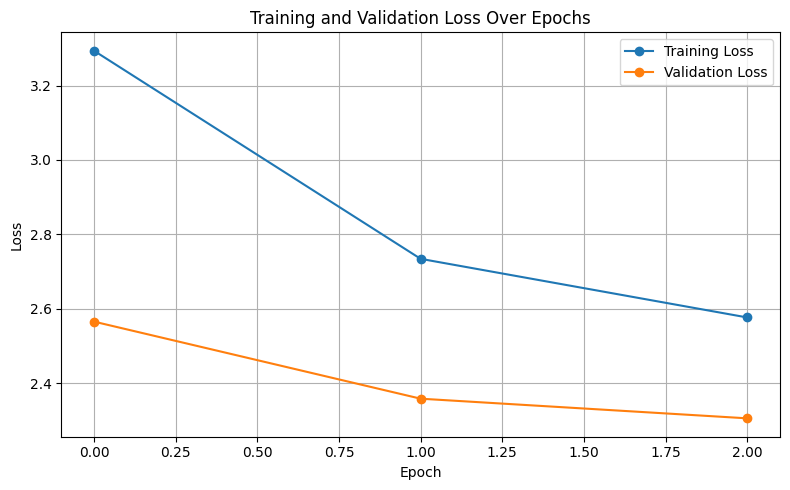

In [220]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import evaluate
from tqdm import tqdm

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
f1_metric = evaluate.load("f1")


# decode predictions
def generate_answers(batch):
    inputs = tokenizer(batch["clean_question"], return_tensors="tf", padding=True, truncation=True)
    output_sequences = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128
    )
    return tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

# Prepare ground truth and predictions
predictions = []
references = []

# Loop through validation examples
for example in tqdm(val_ds, desc="Evaluating"):
    pred = generate_answers({"clean_question": example["clean_question"]})[0]
    ref = example["clean_answer"]

    predictions.append(pred)
    references.append(ref)


Evaluating:  16%|█▌        | 47/299 [23:43<2:05:36, 29.91s/it]

✅ 4. 📊 Compute Metrics

#BLEU



In [ ]:
bleu_result = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU Score:", bleu_result["bleu"])

##ROUGE

In [ ]:
rouge_result = rouge_metric.compute(predictions=predictions, references=references)
print("ROUGE-L:", rouge_result["rougeL"])

##F1
Note: evaluate’s F1 is for classification tasks. For Q&A, we compute token-level F1 manually:

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def compute_token_f1(preds, refs):
    f1_scores = []
    for p, r in zip(preds, refs):
        p_tokens = p.lower().split()
        r_tokens = r.lower().split()
        common = set(p_tokens) & set(r_tokens)

        if len(p_tokens) == 0 or len(r_tokens) == 0:
            f1_scores.append(0)
            continue

        precision = len(common) / len(p_tokens)
        recall = len(common) / len(r_tokens)

        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return np.mean(f1_scores)

token_f1 = compute_token_f1(predictions, references)
print("Token-level F1 Score:", token_f1)
